Phase 2 Extension: Cross-environment behavioural validation in 80-20 vs 70-30 bandits 

This notebook evaluates whether the behavioural mechanisms proposed in the paper generalise across reward uncertainty levels. 
Instead of generating synthetic tasks, models are run on the actual state sequences experienced by mice in both the 80-20 and 70-30 bandit conditions.

Models:
RFLR - agent simulated using mouse-fit parameters in each condition
HMM Thompson Sampling - ideal Bayesian observer using true task parameters
Sticky / Cost-Gated HMM - Bayesian inference with stickiness derived from RFLR parameters

Metrics:
Reward per session - overall efficiency
Reward per switch - switch efficiency
Switching rate - behavioural strategy

Hypothesis:
Increasing environmental uncertainty (70-30) will cause the ideal Bayesian observer (HMM) to over-switch due to sensitivity to noisy evidence, reducing reward efficiency. Moreover, models incorporating stickiness (RFLR and Sticky HMM) are expected to better match mouse behaviour by maintaining efficient switching and higher reward per switch. 

In [1]:
# Imports and paths
import os, sys
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

cwd = os.getcwd()  # Current working directory

# Finding the repo root
if os.path.exists(os.path.join(cwd, "reproduction", "2ABT_behaviour_models")):
    PROJECT_ROOT = cwd
elif os.path.exists(os.path.join(cwd, "..", "reproduction", "2ABT_behaviour_models")):
    PROJECT_ROOT = os.path.abspath(os.path.join(cwd, ".."))
else:
    raise FileNotFoundError(
        "Could not locate reproduction/2ABT_behaviour_models from current working directory"
    )

BEHAV_DIR = os.path.join(PROJECT_ROOT, "reproduction", "2ABT_behaviour_models")
if BEHAV_DIR not in sys.path:
    sys.path.insert(0, BEHAV_DIR)

# Import code from the original github
import model_simulations as sim
import model_fitting as fit

# Output directory where plots and cvs are saved
OUTDIR = os.path.join(PROJECT_ROOT, "Extensions", "phase2_generative")
os.makedirs(OUTDIR, exist_ok=True)

np.random.seed(0)  # Make randomness reproducible

/Users/lenkaokasova/Documents/GitHub/stochastic-switching-bandits/.venv-vscode/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load mouse data (REAL sessions + REAL latent states from Target)
df = pd.read_csv(os.path.join(BEHAV_DIR, "bandit_data.csv")).copy()

# Keep only the two conditions
df = df[df["Condition"].isin(["70-30", "80-20"])].copy()

# Sort - sessions are in correct trial order
df = df.sort_values(["Session", "Trial"])
# Ensure trials are chronological within each session


def build_sessions_and_states(df_cond):
    mouse_sessions = []  # list of choices, rewards
    state_sessions = []  # list of state arrays (Target)
    meta = []  # Mouse, Session

    for sess, g in df_cond.groupby("Session"):
        # g = one session worth of trials
        choices = g["Decision"].astype(int).to_numpy()  # Choice per trial
        rewards = g["Reward"].astype(int).to_numpy()  # Reward per trial
        states = (
            g["Target"].astype(int).to_numpy()
        )  # True latent correct side per trial

        mouse_sessions.append((choices, rewards))  # Store mouse behaviour
        state_sessions.append(states)  # Store the true state sequence
        meta.append((g["Mouse"].iloc[0], sess))  # Mouse ID and session ID

    return mouse_sessions, state_sessions, meta


df80 = df[df["Condition"] == "80-20"].copy()  # Subset to 80-20
df70 = df[df["Condition"] == "70-30"].copy()  # Subset to 70-30

mouse_sessions_80, states_80_real, meta_80 = build_sessions_and_states(df80)
mouse_sessions_70, states_70_real, meta_70 = build_sessions_and_states(df70)

len(mouse_sessions_80), len(mouse_sessions_70), len(states_80_real), len(states_70_real)

(159, 200, 159, 200)

In [3]:
# Fit RFLR on Mouse 80-20 and 70-30 - real data

# Fit on 80-20
rflr_params_80, nll_80 = fit.fit_with_sgd(
    fit.log_probability_rflr,  # Objective: log probability under RFLR
    mouse_sessions_80,  # Data: choices and rewards from mice in 80-20
    num_steps=4000,  # SGD iterations
    step_size=1e-2,  # Learning rate
    init_parameters=(0.0, 1.0, 2.0),  # Starting guess for alpha, beta and tau
)
alpha_80, beta_80, tau_80 = map(float, rflr_params_80)  # Unpack the fitted parameters

# Fit on 70-30
rflr_params_70, nll_70 = fit.fit_with_sgd(
    fit.log_probability_rflr,
    mouse_sessions_70,  # Data: mice in 70-30
    num_steps=4000,
    step_size=1e-2,
    init_parameters=(0.0, 1.0, 2.0),
)
alpha_70, beta_70, tau_70 = map(float, rflr_params_70)

(alpha_80, beta_80, tau_80), (alpha_70, beta_70, tau_70), (nll_80, nll_70)

iteration  0 neg ll:  0.25747707
iteration  1000 neg ll:  0.18779886
iteration  2000 neg ll:  0.18509173
iteration  3000 neg ll:  0.1840569
iteration  0 neg ll:  0.30199584
iteration  1000 neg ll:  0.20443213
iteration  2000 neg ll:  0.2003353
iteration  3000 neg ll:  0.1991485


((0.7112466096878052, 1.6068638563156128, 1.982416033744812),
 (0.9394705295562744, 1.6236896514892578, 2.0656580924987793),
 (Array(0.18341245, dtype=float32, weak_type=True),
  Array(0.19851546, dtype=float32, weak_type=True)))

In [4]:
# Estimate p_switch from real Target sequences
def estimate_p_switch(state_sessions):
    # probability that Target changes from t to t+1
    changes = 0
    total = 0
    for s in state_sessions:
        if len(s) < 2:
            continue  # Skip tiny sessions
        changes += (s[1:] != s[:-1]).sum()  # Count state flips
        total += len(s) - 1  # Total transitions
    return changes / total if total > 0 else np.nan


p_switch_80 = estimate_p_switch(states_80_real)  # Empirical flip rate in 80-20
p_switch_70 = estimate_p_switch(states_70_real)  # Empirical flip rate in 70-30

p_switch_80, p_switch_70

(0.01965436313206742, 0.02006180821350988)

In [5]:
# Simulate RFLR generatively on real state sequences
from scipy.special import expit as sigmoid  # Expit = logistic sigmoid


def run_rflr_on_states(states_list, alpha, beta, tau, p_reward):
    gamma = np.exp(-1.0 / tau)  # Exponential decay factor for phi memory
    sessions = []

    for states in states_list:
        states = np.asarray(states, dtype=int)  # Convert to numpy array (0/1)
        T = len(states)  # Number of trials

        choices = np.zeros(T, dtype=int)  # Simulated choices
        rewards = np.zeros(T, dtype=int)  # Simulated rewards
        psis = np.zeros(T, dtype=float)  # Store decision variable psi each step

        choices[0] = np.random.randint(2)  # random first choice

        # Reward generation: if choice matches Target - reward with p_reward, otherwise with 1-p_reward
        rewards[0] = int(
            np.random.rand() < (p_reward if choices[0] == states[0] else 1 - p_reward)
        )

        # Initialize phi (latent variable)
        phi = beta * rewards[0] * (2 * choices[0] - 1)

        # Iterate trials 1 to T-1
        for t in range(1, T):
            # Psi combines current value estimate (phi) and stickiness (alpha * last choice)
            psi = phi + alpha * (2 * choices[t - 1] - 1)
            psis[t] = psi

            # Choose action stochastically by logistic(psi)
            choices[t] = int(np.random.rand() < sigmoid(psi))

            # Generate reward from environment using true state
            rewards[t] = int(
                np.random.rand()
                < (p_reward if choices[t] == states[t] else 1 - p_reward)
            )

            # Update phi with decay and reward prediction influence
            phi = gamma * phi + beta * rewards[t] * (2 * choices[t] - 1)

        sessions.append([choices, rewards, psis])  # Store one simulated session

    return sessions


# Run RFLR using condition specific fitted parameters
rflr_80 = run_rflr_on_states(states_80_real, alpha_80, beta_80, tau_80, p_reward=0.8)
rflr_70 = run_rflr_on_states(states_70_real, alpha_70, beta_70, tau_70, p_reward=0.7)

len(rflr_80), len(rflr_70)

(159, 200)

In [6]:
# Simulate HMM Thompson Sampling on REAL state sequences (ideal observer)


def run_hmm_sessions(states_list, p_reward, p_switch):
    all_sessions = []
    for states in states_list:
        # Create BayesianMouse agent - knows p_reward and p_switch
        mouse = sim.BayesianMouse({"p_switch": p_switch, "p_reward": p_reward})

        # Simulate one session
        out = sim.simulate_experiment(
            params={"p_reward": p_reward},  # Passed in but mostly redundant
            mouse=mouse,  # Agent
            states=[states],  # List with one session's state
            policy="thompson",  # Thompson sampling policy
            sticky=False,  # No stickiness correction
        )

        # simulate_experiment returns a list of sessions and extend collects them
        all_sessions.extend(out)
    return all_sessions


hmm_80 = run_hmm_sessions(states_80_real, p_reward=0.8, p_switch=p_switch_80)
hmm_70 = run_hmm_sessions(states_70_real, p_reward=0.7, p_switch=p_switch_70)

len(hmm_80), len(hmm_70)

(159, 200)

In [7]:
# Simulate Sticky / Cost-Gated HMM on real state sequences


def run_sticky_sessions(states_list, p_reward, p_switch, alpha, beta, tau):
    all_sessions = []
    for states in states_list:
        # BayesianMouse with extra parameters used by sticky correction
        mouse = sim.BayesianMouse(
            {
                "p_switch": p_switch,
                "p_reward": p_reward,
                "alpha": alpha,
                "beta": beta,
                "tau": tau,
            }
        )
        out = sim.simulate_experiment(
            params={"p_reward": p_reward},
            mouse=mouse,
            states=[states],
            policy="thompson",
            sticky=True,  # Turn on stickiness correction
        )
        all_sessions.extend(out)
    return all_sessions


sticky_80 = run_sticky_sessions(
    states_80_real,
    p_reward=0.8,
    p_switch=p_switch_80,
    alpha=alpha_80,
    beta=beta_80,
    tau=tau_80,
)
sticky_70 = run_sticky_sessions(
    states_70_real,
    p_reward=0.7,
    p_switch=p_switch_70,
    alpha=alpha_70,
    beta=beta_70,
    tau=tau_70,
)

len(sticky_80), len(sticky_70)

(159, 200)

In [8]:
# Metric Extraction


def metrics(sessions):
    rows = []
    for c, r, *_ in sessions:
        # c: choices array, r: rewards array, *_ ignores extra outputs
        switches = np.sum(c[1:] != c[:-1])  # Count choice switches
        rows.append(
            {
                "reward_per_session": r.mean(),  # Average reward per trial - session mean
                "reward_per_switch": r.sum()
                / max(1, switches),  # Total reward / number of switches
                "switches": switches,
            }
        )
    return pd.DataFrame(rows)


# Combine mouse sessions and model sessions into one data frame
summary = pd.concat(
    [
        metrics(mouse_sessions_80).assign(model="Mouse", cond="80-20"),
        metrics(mouse_sessions_70).assign(model="Mouse", cond="70-30"),
        metrics(hmm_80).assign(model="HMM", cond="80-20"),
        metrics(hmm_70).assign(model="HMM", cond="70-30"),
        metrics(rflr_80).assign(model="RFLR", cond="80-20"),
        metrics(rflr_70).assign(model="RFLR", cond="70-30"),
        metrics(sticky_80).assign(model="Sticky HMM", cond="80-20"),
        metrics(sticky_70).assign(model="Sticky HMM", cond="70-30"),
    ],
    ignore_index=True,
)

summary.head()

,reward_per_session,reward_per_switch,switches,model,cond
0,0.695712,7.397059,68,Mouse,80-20
1,0.712500,9.500000,60,Mouse,80-20
2,0.700389,10.384615,52,Mouse,80-20
3,0.696078,13.209302,43,Mouse,80-20
4,0.742033,12.868421,38,Mouse,80-20


In [9]:
# Save every session as a row
summary.to_csv(
    os.path.join(OUTDIR, "summary_real_vs_models_by_session.csv"),
    index=False,
)

# Save aggregated means per model/condition
summary.groupby(["model", "cond"]).mean(numeric_only=True).to_csv(
    os.path.join(OUTDIR, "summary_real_vs_models_means.csv")
)

In [10]:
from scipy.stats import (
    mannwhitneyu,
)  # Nonparametric 2-sample test used to compare conditions within model


def fdr_bh(pvals):
    pvals = np.asarray(pvals, dtype=float)
    n = len(pvals)
    order = np.argsort(pvals)  # Rank p-values
    ranked = pvals[order]
    adj = ranked * n / (np.arange(1, n + 1))  # Benjamin-Hochberg adjustment
    adj = np.minimum.accumulate(adj[::-1])[::-1]  # Enforce monotonicity
    adj = np.clip(adj, 0, 1)  # Keep in [0,1]
    out = np.empty_like(adj)
    out[order] = adj  # Return to original order
    return out


metrics = ["reward_per_session", "reward_per_switch", "switches"]
models_cond = ["Mouse", "HMM", "RFLR", "Sticky HMM"]

cond_rows = []
# Loop over each model separately
for m in models_cond:
    d = summary[
        summary["model"] == m
    ]  # d = all sessions from one model across both environments
    # Loop over each behavioural metric
    for met in metrics:
        x70 = (
            d.loc[d["cond"] == "70-30", met].dropna().values
        )  # Extract the values for this metric in the 70-3- environment
        x80 = (
            d.loc[d["cond"] == "80-20", met].dropna().values
        )  # Extract the values for this metric in the 70-3- environment

        # Perform Mann-Whitney U test (non-parametric comparison)
        U, p = mannwhitneyu(x70, x80, alternative="two-sided")

        # Store the result as one row in the results list
        cond_rows.append(
            {
                "model": m,  # Model tested
                "metric": met,  # Behavioural metric
                "U": U,  # Mann_Whitney test statistic
                "p": p,  # Raw p-value
                "med_70": np.median(x70),  # Median value in 70-30 condition
                "med_80": np.median(x80),  # Median value in 80-20 condition
                "n_70": len(x70),  # Number of sessions in 70-30
                "n_80": len(x80),  # Number of sessions in 80-20
            }
        )
# Convert list to dictionaries into DataFrame table
cond_compare = pd.DataFrame(cond_rows)

# Apply False Discovery Rate (Benjamin-Hochberg) correction - adjusts p-values as multpiple statistical tests were performed
cond_compare["p_fdr"] = fdr_bh(cond_compare["p"].values)

# Sort results
cond_compare = cond_compare.sort_values(["metric", "p_fdr"])

# Save results
cond_compare.to_csv(
    os.path.join(OUTDIR, "stats_condition_within_model.csv"), index=False
)

cond_compare

,model,metric,U,p,med_70,med_80,n_70,n_80,p_fdr
3,HMM,reward_per_session,24.0,2.101513e-59,0.611999,0.717687,200,159,1.566545e-58
9,Sticky HMM,reward_per_session,37.0,2.610908e-59,0.622322,0.729196,200,159,1.566545e-58
0,Mouse,reward_per_session,355.0,4.998278e-57,0.593856,0.700709,200,159,1.199587e-56
6,RFLR,reward_per_session,342.0,4.040437e-57,0.596148,0.688185,200,159,1.199587e-56
4,HMM,reward_per_switch,192.0,3.426220e-58,2.588642,4.661017,200,159,1.370488e-57
10,Sticky HMM,reward_per_switch,8568.0,6.087871e-14,16.363636,20.875000,200,159,1.043635e-13
7,RFLR,reward_per_switch,10232.0,6.532037e-09,8.270209,9.418182,200,159,9.798055e-09
1,Mouse,reward_per_switch,13496.5,1.388392e-02,9.148148,10.716981,200,159,1.666070e-02
5,HMM,switches,30317.5,2.605138e-49,181.000000,113.000000,200,159,5.210276e-49
11,Sticky HMM,switches,20175.0,1.187799e-05,29.000000,26.000000,200,159,1.583732e-05


In [11]:
# Create a mean table used for plotting
compare = summary.groupby(["model", "cond"], as_index=False).agg(
    reward_per_switch=("reward_per_switch", "mean"),
    switches=("switches", "mean"),
    reward_per_session=("reward_per_session", "mean"),
)
compare

,model,cond,reward_per_switch,switches,reward_per_session
0,HMM,70-30,2.651646,181.595000,0.611672
1,HMM,80-20,4.747256,114.018868,0.715726
2,Mouse,70-30,11.959709,51.600000,0.595112
3,Mouse,80-20,12.665735,49.044025,0.695531
4,RFLR,70-30,8.546039,55.940000,0.595454
5,RFLR,80-20,9.855666,53.918239,0.689049
6,Sticky HMM,70-30,17.154890,30.340000,0.622533
7,Sticky HMM,80-20,22.022065,26.446541,0.728796


In [12]:
cond_order = ["70-30", "80-20"]
model_order = ["Mouse", "HMM", "RFLR", "Sticky HMM"]
model_colors = {
    "Mouse": "black",
    "HMM": "#1f77b4",  # blue
    "RFLR": "#ff7f0e",  # orange
    "Sticky HMM": "#2ca02c",  # green
}

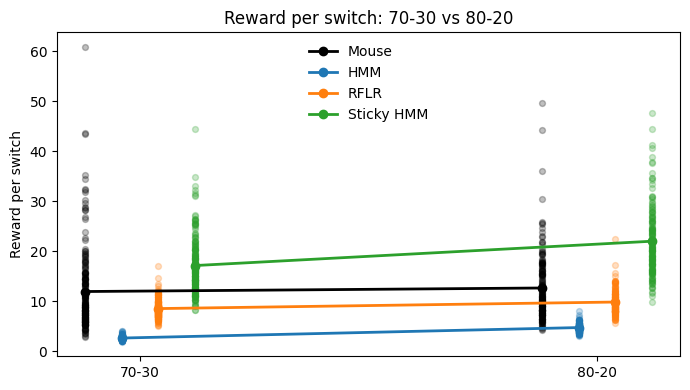

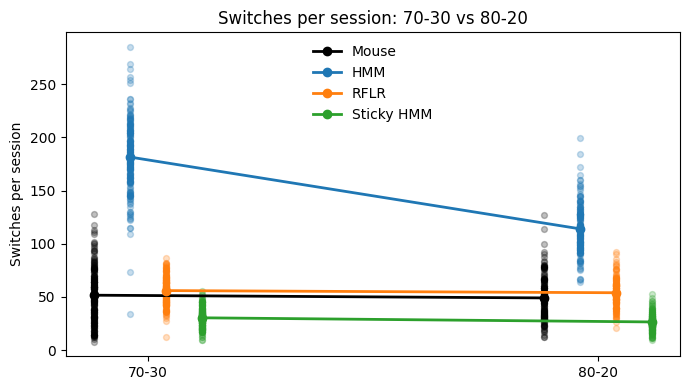

In [13]:
for metric, ylabel, fname in [
    ("reward_per_switch", "Reward per switch", "cmp_reward_per_switch_points.png"),
    ("switches", "Switches per session", "cmp_switches_points.png"),
]:
    plt.figure(figsize=(7, 4))

    for i, m in enumerate(model_order):
        s_raw = summary[summary["model"] == m].copy()
        s_raw["cond"] = pd.Categorical(
            s_raw["cond"], categories=cond_order, ordered=True
        )
        s_raw = s_raw.sort_values("cond")

        # optional dodge
        offset = (i - (len(model_order) - 1) / 2) * 0.08
        x_map = {c: j for j, c in enumerate(cond_order)}

        x = s_raw["cond"].map(x_map).astype(float).to_numpy() + offset
        y = s_raw[metric].to_numpy()
        plt.scatter(x, y, s=18, alpha=0.25, color=model_colors[m])

        # mean line from compare table
        s_mean = compare[compare["model"] == m].copy()
        s_mean["cond"] = pd.Categorical(
            s_mean["cond"], categories=cond_order, ordered=True
        )
        s_mean = s_mean.sort_values("cond")
        xm = s_mean["cond"].map(x_map).astype(float).to_numpy() + offset
        ym = s_mean[metric].to_numpy()
        plt.plot(xm, ym, "o-", label=m, color=model_colors[m], linewidth=2)

    plt.xticks([0, 1], cond_order)
    plt.ylabel(ylabel)
    plt.title(f"{ylabel}: 70-30 vs 80-20")
    plt.legend(loc="upper center", frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, fname), dpi=300, bbox_inches="tight")
    plt.show()

RFLR Generalization Analysis - Pooled and cross-condition fits

To test whether a single decision policy explains behaviour across environments, we evaluate the generalization performance of the RFLR model across reward conditions. 

Three fitting procedures are performed: 

1) Fit RFLR on 80-20 only - evaluate on 80-20 (in-condition prediction) and 70-30 (cross-condition generalization)

2) Fit RFLR on 70-30 only - evaluate on 70-30 (in-condition prediction) and 80-20 (cross-condition generalization)

3) Fit RFLR on pooled data (combined 80-20 and 70-30 sessions) - evaluate performance on both environments

Held-out evaluation with a train/test split - For each fitting procedure, sessions are split into training and test sets, and performance is evaluated only on unseen test sessions.

Outcome measure:
Model performance is quantified using held-out negative log-likelihood per transition, providing a measure of out-of-environment predictive performance and indicating whether the inferred decision policy generalizes across uncertainty levels.

In [14]:
# Helpers - fit, score and split
def fit_rflr_params(sessions, num_steps=4000, step_size=1e-2, init=(0.0, 1.0, 2.0)):
    # Fit RFLR parameters (alpha,beta,tau) by SGD
    params, mean_nll = fit.fit_with_sgd(
        fit.log_probability_rflr,
        sessions,
        num_steps=num_steps,
        step_size=step_size,
        init_parameters=init,
    )
    alpha, beta, tau = map(float, params)
    return (alpha, beta, tau), float(mean_nll)


def score_rflr(params, sessions):
    # Evaluate fixed params on a dataset
    # log_probability_rflr returns mean log-likelihood per transition (higher is better), return mean NLL per transition for convenience (lower is better)
    mean_ll = float(fit.log_probability_rflr(params, sessions))
    mean_nll = -mean_ll
    return mean_ll, mean_nll


def count_transitions(sessions):
    # Total number of choice transitions across sessions
    return int(sum(len(c) - 1 for (c, r) in sessions))


# Train/test split helper
def split_sessions(sessions, test_frac=0.2, seed=0):
    # Split at the session level (not trial level), so sessions are independent units
    rng = np.random.default_rng(seed)
    idx = np.arange(len(sessions))
    rng.shuffle(idx)
    k = int(round(len(idx) * (1 - test_frac)))
    train_idx, test_idx = idx[:k], idx[k:]
    train = [sessions[i] for i in train_idx]
    test = [sessions[i] for i in test_idx]
    return train, test

In [15]:
# Build pooled dataset
mouse_sessions_pool = mouse_sessions_70 + mouse_sessions_80

# Fit RFLR on each training set
p80, nll_train_80 = fit_rflr_params(mouse_sessions_80)
p70, nll_train_70 = fit_rflr_params(mouse_sessions_70)
ppool, nll_train_pool = fit_rflr_params(mouse_sessions_pool)

print("Fit on 80-20  params:", p80, "mean NLL(train80):", nll_train_80)
print("Fit on 70-30  params:", p70, "mean NLL(train70):", nll_train_70)
print("Fit pooled    params:", ppool, "mean NLL(trainpool):", nll_train_pool)

iteration  0 neg ll:  0.25747707
iteration  1000 neg ll:  0.18779886
iteration  2000 neg ll:  0.18509173
iteration  3000 neg ll:  0.1840569
iteration  0 neg ll:  0.30199584
iteration  1000 neg ll:  0.20443213
iteration  2000 neg ll:  0.2003353
iteration  3000 neg ll:  0.1991485
iteration  0 neg ll:  0.28280696
iteration  1000 neg ll:  0.19784626
iteration  2000 neg ll:  0.19431125
iteration  3000 neg ll:  0.19316149
Fit on 80-20  params: (0.7112466096878052, 1.6068638563156128, 1.982416033744812) mean NLL(train80): 0.18341244757175446
Fit on 70-30  params: (0.9394705295562744, 1.6236896514892578, 2.0656580924987793) mean NLL(train70): 0.19851545989513397
Fit pooled    params: (0.8523979783058167, 1.6115918159484863, 2.0283591747283936) mean NLL(trainpool): 0.19251227378845215


In [16]:
# Held-out evaluation: split each condition into train/test, then evaluate cross-condition

train80, test80 = split_sessions(mouse_sessions_80, test_frac=0.2, seed=0)
train70, test70 = split_sessions(mouse_sessions_70, test_frac=0.2, seed=0)

train_pool = train70 + train80
test_pool = test70 + test80

# Fit on TRAIN sets only
p80_tr, _ = fit_rflr_params(train80)
p70_tr, _ = fit_rflr_params(train70)
ppool_tr, _ = fit_rflr_params(train_pool)

# Evaluate on TEST sets (within and across)
fits_tr = {"fit_80": p80_tr, "fit_70": p70_tr, "fit_pool": ppool_tr}
tests_te = {"test_80": test80, "test_70": test70}

rows = []
for fit_name, params in fits_tr.items():
    for test_name, sess in tests_te.items():
        mean_ll, mean_nll = score_rflr(params, sess)
        rows.append(
            {
                "fit": fit_name,
                "test": test_name,
                "mean_LL_per_transition": mean_ll,
                "mean_NLL_per_transition": mean_nll,
                "alpha": params[0],
                "beta": params[1],
                "tau": params[2],
                "n_sessions": len(sess),
                "n_transitions": count_transitions(sess),
            }
        )

heldout_table = pd.DataFrame(rows).sort_values(["fit", "test"])
heldout_table

iteration  0 neg ll:  0.25918198
iteration  1000 neg ll:  0.19085106
iteration  2000 neg ll:  0.18821459
iteration  3000 neg ll:  0.18718958
iteration  0 neg ll:  0.30379957
iteration  1000 neg ll:  0.20754042
iteration  2000 neg ll:  0.2035117
iteration  3000 neg ll:  0.20232554
iteration  0 neg ll:  0.28460568
iteration  1000 neg ll:  0.20096081
iteration  2000 neg ll:  0.19749504
iteration  3000 neg ll:  0.1963505


,fit,test,mean_LL_per_transition,mean_NLL_per_transition,alpha,beta,tau,n_sessions,n_transitions
3,fit_70,test_70,-0.185592,0.185592,0.933015,1.617841,2.052971,40,30699
2,fit_70,test_80,-0.170817,0.170817,0.933015,1.617841,2.052971,32,23580
1,fit_80,test_70,-0.190115,0.190115,0.700214,1.602099,1.972818,40,30699
0,fit_80,test_80,-0.171012,0.171012,0.700214,1.602099,1.972818,32,23580
5,fit_pool,test_70,-0.186816,0.186816,0.844317,1.606122,2.017104,40,30699
4,fit_pool,test_80,-0.170407,0.170407,0.844317,1.606122,2.017104,32,23580


In [17]:
# Extract the out-of-environment rows (cross-condition) for reporting
# Out-of-environment means: fit_80 tested on 70 AND fit_70 tested on 80
def pick_row(df, fit_name, test_name):
    return df[(df["fit"] == fit_name) & (df["test"] == test_name)].iloc[0]


ooe = pd.DataFrame(
    [
        dict(
            setting="In-sample 80",
            **pick_row(heldout_table, "fit_80", "test_80").to_dict()
        ),
        dict(
            setting="Cross 80→70",
            **pick_row(heldout_table, "fit_80", "test_70").to_dict()
        ),
        dict(
            setting="In-sample 70",
            **pick_row(heldout_table, "fit_70", "test_70").to_dict()
        ),
        dict(
            setting="Cross 70→80",
            **pick_row(heldout_table, "fit_70", "test_80").to_dict()
        ),
        dict(
            setting="Pooled→80",
            **pick_row(heldout_table, "fit_pool", "test_80").to_dict()
        ),
        dict(
            setting="Pooled→70",
            **pick_row(heldout_table, "fit_pool", "test_70").to_dict()
        ),
    ]
)

# Keep only the key columns for readability
ooe[
    [
        "setting",
        "mean_NLL_per_transition",
        "mean_LL_per_transition",
        "alpha",
        "beta",
        "tau",
        "n_sessions",
        "n_transitions",
    ]
]

,setting,mean_NLL_per_transition,mean_LL_per_transition,alpha,beta,tau,n_sessions,n_transitions
0,In-sample 80,0.171012,-0.171012,0.700214,1.602099,1.972818,32,23580
1,Cross 80→70,0.190115,-0.190115,0.700214,1.602099,1.972818,40,30699
2,In-sample 70,0.185592,-0.185592,0.933015,1.617841,2.052971,40,30699
3,Cross 70→80,0.170817,-0.170817,0.933015,1.617841,2.052971,32,23580
4,Pooled→80,0.170407,-0.170407,0.844317,1.606122,2.017104,32,23580
5,Pooled→70,0.186816,-0.186816,0.844317,1.606122,2.017104,40,30699
